# Introducing What-If Analysis

Now with [Amazon Forecast](https://aws.amazon.com/forecast/), you can seamlessly conduct what-if analyses up to 80% faster to analyze and quantify the potential impact of business levers on your demand forecasts. Forecast is a service that uses machine learning (ML) to generate accurate demand forecasts, without requiring any ML experience. Simulating scenarios through what-if analyses is a powerful business tool to navigate through the uncertainty of future events by capturing possible outcomes from hypothetical scenarios. It’s a common practice to assess the impact of business decisions on revenue or profitability, quantify the risk associated with market trends, evaluate how to organize logistics and workforce to meet customer demand, and much more.

This notebooks demonstrates how to utillize the What-If feature by using newly available API calls.  First, the notebook uses a sample, synthetic dataset to build a baseline forecast using the "true" product price.  Next, the example leads you through the process of creating a what-if analysis that includes two price reduction simulations.  Price reduction scenario 1 will offer a 10% discount; scenario 2 will offer a 20% discount.  With the scenarios created, the notebook will show you to generate a forecast for each of these.  Finally, the notebook shows you how to compare the baseline forecast against the "discounted" forecast.  Using this generic technique, you can make a business decision -- choosing a price point that is most likely to maximize profit for your company.

Workflow as follows:

1. [Import libraries and setup AWS resources](#import_and_setup)
2. [Upload demo CSVs to S3](#upload)
3. [Create DatasetGroup and Datasets](#create_dsg_ds)
4. [Import the target time series data and related time series](#import)
5. [Create Predictor](#create_predictor)
6. [Create Forecast to produce a baseline](#forecast)
7. [Create What-If Analysis](#whatifanalysis)
8. [Create What-If Forecast](#whatifforecast)
9. [Export What-If Forecast](#forecastexport)
10. [Download and Visualize](#download)
11. [Resource Cleanup](#cleanup)

## Import libraries and setup AWS resources <a class="anchor" id="import_and_setup">
    
Before proceeding, ensure you have upgraded boto3 as follows, so the latest API is available to you.

In [ ]:
!pip install boto3 --upgrade

In [1]:
import sys
import os
import time
import datetime
import io
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import boto3

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util
import json

Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [2]:
bucket_name = 'input your existing S3 bucket name'
region = 'us-west-2'

In [3]:
session = boto3.Session(region_name=region)
s3 = session.client('s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

assert forecast.list_what_if_analyses()

In [4]:
from sagemaker import get_execution_role
role_arn = get_execution_role()

## Upload to S3 <a class="anchor" id="upload">
Here, we will view the dataset locally, then upload the file to Amazon S3. Amazon Forecast consumes input data from S3.
    
A sample [Target Time Series](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/TargetTimeSeries.md) (TTS) and [Related Time Series](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/RelatedTimeSeries.md) (RTS) file is provided.  Please visit the links here to learn more about target and related time series.

An important note with this dataset.  The TTS ends on 2019-09-01, the RTS ends on 2019-12-01.  When performing what-if scenarios, it's important to manipulate RTS variables beyond your known time horizon in TTS.

In [7]:
df_tts = pd.read_csv('./data/consumer_electronics_TTS.csv', low_memory=False)
df_tts.head(5)

,item_id,store_id,timestamp,demand
0,item_001,store_001,2017-10-01,305.824943
1,item_001,store_001,2017-11-01,276.942940
2,item_001,store_001,2017-12-01,277.608189
3,item_001,store_001,2018-01-01,275.940622
4,item_001,store_001,2018-02-01,272.387060


In [8]:
df_rts = pd.read_csv('./data/consumer_electronics_RTS.csv', low_memory=False)
df_rts.head(5)

,item_id,store_id,timestamp,price
0,item_001,store_001,2017-10-01,103.00000
1,item_001,store_001,2017-11-01,110.79548
2,item_001,store_001,2017-12-01,110.79548
3,item_001,store_001,2018-01-01,110.79548
4,item_001,store_001,2018-02-01,110.79548


Upload these files to Amazon S3

In [9]:
project = "whatif_analysis"

key_tts = "%s/consumer_electronics_TTS.csv" % project
key_rts = "%s/consumer_electronics_RTS.csv" % project

s3.upload_file( Filename="./data/consumer_electronics_TTS.csv", Bucket=bucket_name, Key=key_tts )
s3.upload_file( Filename="./data/consumer_electronics_RTS.csv", Bucket=bucket_name, Key=key_rts )

s3_data_path_tts = "s3://" + bucket_name + "/" + key_tts
s3_data_path_rts = "s3://" + bucket_name + "/" + key_rts

# Create DatasetGroup and Datasets <a class="anchor" id="create_dsg_ds">
    
You can read more about Datasets and Dataset Groups [here](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/Datasets.md).

In [10]:
response = forecast.create_dataset_group(
    DatasetGroupName = project + "_dsg",
    Domain="CUSTOM",
    )

dataset_group_arn = response['DatasetGroupArn']

In [11]:
DATASET_FREQUENCY = "M"
TIMESTAMP_FORMAT = "yyyy-MM-dd"

schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"store_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
   ]
}

response = forecast.create_dataset(
    Domain = "CUSTOM",
    DatasetType = 'TARGET_TIME_SERIES',
    DatasetName = project + "_tts",
    DataFrequency = DATASET_FREQUENCY, 
    Schema = schema
)

tts_dataset_arn = response['DatasetArn']

In [12]:
schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"store_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"price",
         "AttributeType":"float"
      },
   ]
}

response = forecast.create_dataset(
    Domain = "CUSTOM",
    DatasetType = 'RELATED_TIME_SERIES',
    DatasetName = project + "_rts",
    DataFrequency = DATASET_FREQUENCY, 
    Schema = schema
)

rts_dataset_arn = response['DatasetArn']

In [13]:
forecast.update_dataset_group( 
    DatasetGroupArn = dataset_group_arn, 
    DatasetArns = [
        tts_dataset_arn,
        rts_dataset_arn,
    ]
)

{'ResponseMetadata': {'RequestId': '9826c838-871d-4339-8bd8-d45eb0905115',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 20 Aug 2022 21:58:44 GMT',
   'x-amzn-requestid': '9826c838-871d-4339-8bd8-d45eb0905115',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Import the target time series data and related time series <a class="anchor" id="import">
    

Start the import task for TTS

In [14]:
response = forecast.create_dataset_import_job(
    DatasetImportJobName = project + "_tts_import",
    DatasetArn = tts_dataset_arn,
    DataSource = {
        "S3Config" : {
            "Path" : s3_data_path_tts,
            "RoleArn" : role_arn
        }
    },
    TimestampFormat = TIMESTAMP_FORMAT
)

tts_dataset_import_job_arn = response['DatasetImportJobArn']

Start the import task for RTS

In [15]:
response = forecast.create_dataset_import_job(
    DatasetImportJobName = project + "_rts_import",
    DatasetArn = rts_dataset_arn,
    DataSource = {
        "S3Config" : {
            "Path" : s3_data_path_rts,
            "RoleArn" : role_arn
        }
    },
    TimestampFormat = TIMESTAMP_FORMAT
)

rts_dataset_import_job_arn = response['DatasetImportJobArn']

Poll and wait on the import tasks, running in parallel, to complete.

In [16]:
print(f"Waiting for TTS dataset import job to become ACTIVE.\nStatus:")
status = util.wait(lambda: forecast.describe_dataset_import_job( DatasetImportJobArn = tts_dataset_import_job_arn ))

print(f"Waiting for RTS dataset import job to become ACTIVE.\nStatus:")
status = util.wait(lambda: forecast.describe_dataset_import_job( DatasetImportJobArn = rts_dataset_import_job_arn ))


Waiting for TTS dataset import job to become ACTIVE.
Status:
CREATE_PENDING ..
CREATE_IN_PROGRESS .........
ACTIVE 
Waiting for RTS dataset import job to become ACTIVE.
Status:
CREATE_IN_PROGRESS ....................
ACTIVE 


## Create Predictor <a class="anchor" id="create_predictor">

Creating a Predictor based on the dataset contents we imported. We will re-use this Predictor to generate two variasions of forecasts.  Please read about the [Auto Predictor](https://github.com/aws-samples/amazon-forecast-samples/blob/main/library/content/AutoPredictor.md) to learn more.

In [17]:
PREDICTOR_NAME = project + "_predictor"
forecast_horizon = 3

create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = forecast_horizon,
                                   ForecastFrequency = DATASET_FREQUENCY,
                                   ForecastDimensions = ["store_id"],
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn
                                    })

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Waiting for Predictor to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))

describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
print(f"\n\nThe Predictor is now {describe_auto_predictor_response['Status']}.")

Waiting for Predictor to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.

Current Status:
CREATE_PENDING 
CREATE_IN_PROGRESS .............................................................................................................................................................................................................................................................................................................
ACTIVE 


The Predictor is now ACTIVE.


## Create Forecast from the true/baseline values in related time series dataset <a class="anchor" id="forecast">

Here, we call create_forecast() API to produce future dated predictions from the imported data, using the trained predictor model from the prior step.  This example produces predictions at the mean quantile, thus 0.50 is used.  You can choose additional quantiles to meet other scenarios.

In [18]:
response = forecast.create_forecast(
    ForecastName = project + "_forecast_baseline",
    ForecastTypes=['0.50'],
    PredictorArn = predictor_arn
)

forecast_arn = response['ForecastArn']

print(f"Waiting for Baseline Forecast to become ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_forecast( ForecastArn = forecast_arn ))

Waiting for Baseline Forecast to become ACTIVE.

Current Status:
CREATE_PENDING ..
CREATE_IN_PROGRESS .......................................................................
ACTIVE 


The next cell demonstrates how it's possible to get singleton responses from the query_forecast() API.  This API can be used for lightweight testing, but it not meant for long term, at-scale use.  The dataset under this API is available for 30 days.  The preferred way to obtain predictions is below in this notebook via the create_what_if_forecast_export() shown, or through the baseline [create_forecast_export_job()](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/forecast.html#ForecastService.Client.create_forecast_export_job).

In [19]:
response = forecastquery.query_forecast(
        ForecastArn = forecast_arn,
        Filters = { "item_id" : 'item_001', "store_id": "store_001" }
    )

response

{'Forecast': {'Predictions': {'p50': [{'Timestamp': '2019-10-01T00:00:00',
     'Value': 327.3666229248},
    {'Timestamp': '2019-11-01T00:00:00', 'Value': 327.0994415283078},
    {'Timestamp': '2019-12-01T00:00:00', 'Value': 320.0594177245906}]}},
 'ResponseMetadata': {'RequestId': '3d9d1f1f-de54-488f-a5e0-ddc61e78b31c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 20 Aug 2022 23:08:21 GMT',
   'x-amzn-requestid': '3d9d1f1f-de54-488f-a5e0-ddc61e78b31c',
   'content-length': '221',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

With a baseline forecast now created, it becomes possible to setup alternate, what-if scenarios and generate corresponding what-if forecasts.  This baseline can be compared against the alternates allowing the business to decide a path forward.

## Create a Named What-If Analysis <a class="anchor" id="whatifanalysis">

A what-if analysis becomes a container for child what-if forecast(s).  What-if forecasts are differ from the forecast above in that they produce outputs that contain the natural forecasted values and the scenario models in the same record set.   This makes it easy to compare the "change" as a result of manipulating the features in the related time series set.

Please observe in the cell below how the What-If Analysis has a name and is attached to an existing baseline forecast in the new <b>create_what_if_analysis()</b> API call.

In [20]:
WhatIfAnalysisName = "PricePromotionAnalysis"

response = forecast.create_what_if_analysis(
    WhatIfAnalysisName=WhatIfAnalysisName,
    ForecastArn=forecast_arn,
)

WhatIfAnalysisArn = response['WhatIfAnalysisArn']

print(f"Waiting for What-if Analysis to become ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_what_if_analysis( WhatIfAnalysisArn = WhatIfAnalysisArn ))

Waiting for What-if Analysis to become ACTIVE.

Current Status:
CREATE_PENDING .
ACTIVE 


## Inside the What-If Analysis, Create a What-If Forecast <a class="anchor" id="whatifforecast">
    
In the next two cells we will create two What-If Forecasts that run in parallel.  One of these examples discounts a products by 10%, the other offers a 20% discount.  To emphasize the point, What-if forecasts are different than baseline forecasts in that they produce outputs that contain the baseline forecasted values and the scenario-models in the same record. 

Having the original baseline value and the what-if value adjacent makes it easy to measure the change as a result of your scenario.  Here, you make a judgement call if the change is something your business wants to adopt.

<b>Scenario 1</b>: Create a 10% off all products, for time period September 1, 2019 and greater.

In [21]:
WhatIfForecastName='simulate_10_pct_off'

response = forecast.create_what_if_forecast(
    WhatIfForecastName=WhatIfForecastName,
    WhatIfAnalysisArn=WhatIfAnalysisArn,
    TimeSeriesTransformations=[
         {
            "Action": {
                "AttributeName": "price",
                "Operation": "MULTIPLY",
                "Value": 0.90
            },
            "TimeSeriesConditions": [
                {
                    "AttributeName": "timestamp",
                    "AttributeValue": "2019-09-01 00:00:00",
                    "Condition": "GREATER_THAN"
                }
              ]
         }
    ]
)

WhatIfForecastArn_10Pct = response['WhatIfForecastArn']

<b>Scenario 2</b>: Create a 20% off product item_001, for time period September 1, 2019 and greater.

In [22]:
WhatIfForecastName='simulate_20_pct_off'

response = forecast.create_what_if_forecast(
    WhatIfForecastName=WhatIfForecastName,
    WhatIfAnalysisArn=WhatIfAnalysisArn,
    TimeSeriesTransformations=[
         {
            "Action": {
                "AttributeName": "price",
                "Operation": "MULTIPLY",
                "Value": 0.80
            },
            "TimeSeriesConditions": [
                {
                    "AttributeName": "timestamp",
                    "AttributeValue": "2019-09-01 00:00:00",
                    "Condition": "GREATER_THAN"
                }
              ]
         }
    ]
)

WhatIfForecastArn_20Pct = response['WhatIfForecastArn']

Poll and wait for both of the what-if forecasts tasks to complete before moving forward.

In [23]:
print(f"Waiting for What-if Forecast to become ACTIVE.\n\nCurrent Status:")

status = util.wait(lambda: forecast.describe_what_if_forecast(WhatIfForecastArn=WhatIfForecastArn_10Pct ))

status = util.wait(lambda: forecast.describe_what_if_forecast(WhatIfForecastArn=WhatIfForecastArn_20Pct ))

Waiting for What-if Forecast to become ACTIVE.

Current Status:
CREATE_PENDING ..
CREATE_IN_PROGRESS ..............................................................................................................................................................
ACTIVE 
ACTIVE 


## Export the What-If Forecast <a class="anchor" id="forecastexport">

<b>Scenario 1</b> Export data to S3

In [24]:
scenario = 'simulate_10_pct_off'

s3_data_path_export = "s3://" + bucket_name + "/" + project + "/" + scenario + "/"

response = forecast.create_what_if_forecast_export(
    WhatIfForecastExportName=scenario,
    WhatIfForecastArns=[WhatIfForecastArn_10Pct],
    Destination={
        "S3Config":  {
            "Path": s3_data_path_export,
            "RoleArn": role_arn,
        }
    }
)

WhatIfForecastExportArn_10Pct= response['WhatIfForecastExportArn']

<b>Scenario 2</b> Export data to S3

In [25]:
scenario = 'simulate_20_pct_off'

s3_data_path_export = "s3://" + bucket_name + "/" + project + "/" + scenario + "/"

response = forecast.create_what_if_forecast_export(
    WhatIfForecastExportName=scenario,
    WhatIfForecastArns=[WhatIfForecastArn_20Pct],
    Destination={
        "S3Config":  {
            "Path": s3_data_path_export,
            "RoleArn": role_arn,
        }
    }
)

WhatIfForecastExportArn_20Pct= response['WhatIfForecastExportArn']

Poll for concurrent export jobs to complete

In [26]:
print(f"Waiting for What-if Forecast Export to become ACTIVE.\n\nCurrent Status:")
status = util.wait(lambda: forecast.describe_what_if_forecast_export(WhatIfForecastExportArn=WhatIfForecastExportArn_10Pct ))
status = util.wait(lambda: forecast.describe_what_if_forecast_export(WhatIfForecastExportArn=WhatIfForecastExportArn_20Pct ))

Waiting for What-if Forecast Export to become ACTIVE.

Current Status:
CREATE_PENDING .
CREATE_IN_PROGRESS .........................
ACTIVE 
CREATE_IN_PROGRESS ................................................................
ACTIVE 


## Download and Visualize <a class="anchor" id="download">

<b>Scenario 1</b>:View tabular results of baseline forecast vs. 10% off forecast.  Note the expected [increase] in demand after the 10% off discount.  

In [34]:
scenario = 'simulate_10_pct_off'

s3_key =  project + "/" + scenario + "/"

#get an arbirary list of 5 files from S3
response = s3.list_objects_v2(
    Bucket=bucket_name,
    EncodingType='url',
    MaxKeys=100,
    Prefix=s3_key
)

df1 = []

# if files are CSV, open, display and plot -- not for actual use, but as an example of art of possible
for i in response['Contents']:
    
    if i['Key'].endswith('.csv'):
        
        obj = s3.get_object(Bucket=bucket_name, Key=i['Key'])
        csv = pd.read_csv(io.BytesIO(obj['Body'].read()))
        df1.append(csv)

df1 = pd.concat(df1)
df1 = df1[(df1['item_id']=='item_001') & (df1['store_id']=='store_001')]
df1 = df1.set_index(keys=['date','item_id','store_id'])
df1.head(10)

,,,Baseline_p50,simulate_10_pct_off_p50
date,item_id,store_id,,
2019-10-01T00:00:00Z,item_001,store_001,327.366623,382.596756
2019-11-01T00:00:00Z,item_001,store_001,327.099442,381.938004
2019-12-01T00:00:00Z,item_001,store_001,320.059418,375.966370


<b>Scenario 2</b>:View tabular results of baseline forecast vs. 20% off forecast

In [35]:
scenario = 'simulate_20_pct_off'

s3_key =  project + "/" + scenario + "/"

#get an arbirary list of 5 files from S3
response = s3.list_objects_v2(
    Bucket=bucket_name,
    EncodingType='url',
    MaxKeys=100,
    Prefix=s3_key
)

df2 = []

# if files are CSV, open, display and plot -- not for actual use, but as an example of art of possible
for i in response['Contents']:
    
    if i['Key'].endswith('.csv'):
        
        obj = s3.get_object(Bucket=bucket_name, Key=i['Key'])
        csv = pd.read_csv(io.BytesIO(obj['Body'].read()))
        df2.append(csv)

df2 = pd.concat(df2)
df2 = df2[(df2['item_id']=='item_001') & (df2['store_id']=='store_001')]
df2 = df2.set_index(keys=['date','item_id','store_id'])
df2.head(10)

,,,simulate_20_pct_off_p50,Baseline_p50
date,item_id,store_id,,
2019-10-01T00:00:00Z,item_001,store_001,442.034897,327.366623
2019-11-01T00:00:00Z,item_001,store_001,439.336487,327.099442
2019-12-01T00:00:00Z,item_001,store_001,434.691040,320.059418


Join the two what-if dataframes and add a placeholder demand column

In [36]:
df2.drop(columns='Baseline_p50', inplace=True)
df_whatif = pd.concat([df1, df2], axis=1)
df_whatif['demand'] = np.nan
df_whatif.head(5)

,,,Baseline_p50,simulate_10_pct_off_p50,simulate_20_pct_off_p50,demand
date,item_id,store_id,,,,
2019-10-01T00:00:00Z,item_001,store_001,327.366623,382.596756,442.034897,NaN
2019-11-01T00:00:00Z,item_001,store_001,327.099442,381.938004,439.336487,NaN
2019-12-01T00:00:00Z,item_001,store_001,320.059418,375.966370,434.691040,NaN


Prepare a historical view of data, the true demand for a named item and store.  This dataframe will be merged with the what-if dataframe, then plotted.

In [45]:
df_history = df_tts[(df_tts['item_id']=='item_001') & (df_tts['store_id']=='store_001')]

df_history.rename(columns={'timestamp': 'date'}, inplace=True)
df_history['date'] = df_history['date'] + 'T00:00:00Z'

df_history = df_history.set_index(keys=['date','item_id','store_id'])

df_history['Baseline_p50'] = np.nan
df_history['simulate_20_pct_off_p50'] = np.nan
df_history['simulate_10_pct_off_p50'] = np.nan

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Join the history dataframe with the predictions -- baseline and two what-if scenarios.

In [46]:
df_history = df_history.append(df_whatif)
df_history = df_history.reset_index()
df_history.tail(6)

,date,item_id,store_id,demand,Baseline_p50,simulate_20_pct_off_p50,simulate_10_pct_off_p50
21,2019-07-01T00:00:00Z,item_001,store_001,315.759707,NaN,NaN,NaN
22,2019-08-01T00:00:00Z,item_001,store_001,320.044658,NaN,NaN,NaN
23,2019-09-01T00:00:00Z,item_001,store_001,325.455626,NaN,NaN,NaN
24,2019-10-01T00:00:00Z,item_001,store_001,NaN,327.366623,442.034897,382.596756
25,2019-11-01T00:00:00Z,item_001,store_001,NaN,327.099442,439.336487,381.938004
26,2019-12-01T00:00:00Z,item_001,store_001,NaN,320.059418,434.691040,375.966370


### Visualize


In the graphic below, historic demand is in blue as 'demand'.  With the price unchanged, the Baseline P50 estimate nearly matches the historic demand.  In the green line, there is clear increase with a 10% off simulation as 'simulate_20_pct_off_p50'.  Finally, the red line at top shows an even larger increase in demand at a 20% off price.

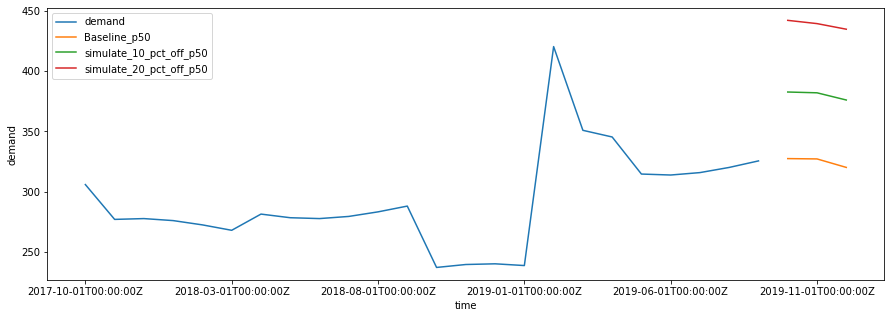

In [58]:
df_history.plot(x='date', y=['demand', 'Baseline_p50','simulate_10_pct_off_p50',
                   'simulate_20_pct_off_p50'], kind ='line', figsize=(15,5))
plt.xlabel('time')
plt.ylabel('demand')
plt.show()  

## Resource cleanup <a class="anchor" id="cleanup">
    This needs to be un-commented for clean-up

In [ ]:
# Delete datasets and dataset group
util.wait_till_delete(lambda: forecast.delete_resource_tree(ResourceArn = dataset_group_arn))
util.wait_till_delete(lambda: forecast.delete_resource_tree(ResourceArn = rts_dataset_arn))
util.wait_till_delete(lambda: forecast.delete_resource_tree(ResourceArn = tts_dataset_arn))

util.wait_till_delete(lambda: forecast.delete_resource_tree(ResourceArn = WhatIfAnalysisArn))